# Trends, anomalies and clustering

- Data from NASA/GSFC GIMMS NDVI3g version 1 1981-07-01 - 2015-12-31 1/12 x 1/12 degrees 1/24 a year.
- Only reggrided data (compatible with ERA-INTERIM grid).
- Linear trends and its statistics for observed data and anomalies.
- Kmeans clustering of observed data.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from scipy import stats
from dask.diagnostics import ProgressBar

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

from sklearn.preprocessing import StandardScaler, RobustScaler

%matplotlib inline

In [4]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [5]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

In [6]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/GIMMS/"

In [7]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 
# meters resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

## Load data

In [8]:
%%time

# List files.
FILES_MMEANS = sorted(glob.glob(DATA_FOLDER + "NDVI_mmeans/*nc4"))

# DataSets objects.
DS_mm = xr.open_mfdataset(FILES_MMEANS)

# South America.
DS_mm = DS_mm.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

# Land mask at ERA-INTERIM grid.
DS_mm = cdlearn.pixels.EraInterimGrid.add_land_mask(DS_mm)

DS_mm

CPU times: user 370 ms, sys: 11.7 ms, total: 381 ms
Wall time: 847 ms


<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 414)
Coordinates:
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
    land_mask  (latitude, longitude) bool True True True ... False False False
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<chunksize=(6, 107, 81), meta=np.ndarray>

In [9]:
# Load data into memory.
DA_mm = DS_mm.ndvi
with ProgressBar():
    DA_mm = DA_mm.compute()

[########################################] | 100% Completed |  3.5s


## Linear trends and its statistics for observed data

In [10]:
# Linear trends and its statistics.
trends, _ = cdlearn.statistics.linear_trends(DA_mm)
linstats = cdlearn.statistics.linear_regression(DA_mm)

# Land mask at ERA-INTERIM grid.
linstats = cdlearn.pixels.EraInterimGrid.add_land_mask(linstats)

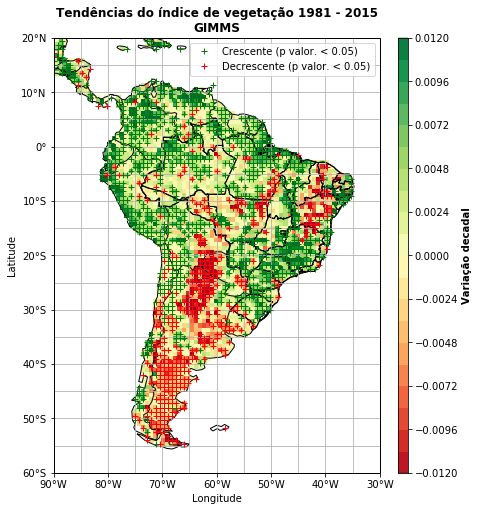

In [11]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.02,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    factor = 120 # Decade.
    data = linstats.sel(stats="slope") * 100
    da = data.where(linstats.land_mask==True)
    p = da.plot(
        ax=axis,
        vmin=-1.0e-4 * factor,
        vmax=1.0e-4 * factor,
        levels=factor * np.arange(-1.0e-4, 1.1e-4, 0.1e-4),
        cmap=plt.cm.RdYlGn,
        add_colorbar=False,
        add_labels=False
    )
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Tendências do índice de vegetação 1981 - 2015\n" + \
                     "GIMMS", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Variação decadal", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0e-4 * factor, (1.0e-4 + 0.2e-4) * factor, 0.2e-4 * factor))

# Statistical significant trends.
mask = linstats.sel(stats="p_value") < 0.05
mask_up = linstats.sel(stats="slope") > 0
mask_down = linstats.sel(stats="slope") < 0
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

# Incresing!
msk = np.logical_and(mask, mask_up)
axis.plot(LON[msk], LAT[msk], "+g", label="Crescente (p valor. < 0.05)", transform=projection)
    
# Decreasing!
msk = np.logical_and(mask, mask_down)
axis.plot(LON[msk], LAT[msk], "+r", label="Decrescente (p valor. < 0.05)", transform=projection)    

# Legend.    
axis.legend() 
    
# Save figure.
plt.savefig(fig_path + "ndvi_gimms_trends_pt.jpg", dpi=200, bbox_inches="tight")

## Linear trends and its statistics for anomalies

In [12]:
# Anomalies.
DA_ano = cdlearn.statistics.anomalies(DA_mm)

In [13]:
# Linear trends and its statistics.
trends_ano, _ = cdlearn.statistics.linear_trends(DA_ano)
linstats_ano = cdlearn.statistics.linear_regression(DA_ano)

# Land mask at ERA-INTERIM grid.
linstats_ano = cdlearn.pixels.EraInterimGrid.add_land_mask(linstats_ano)

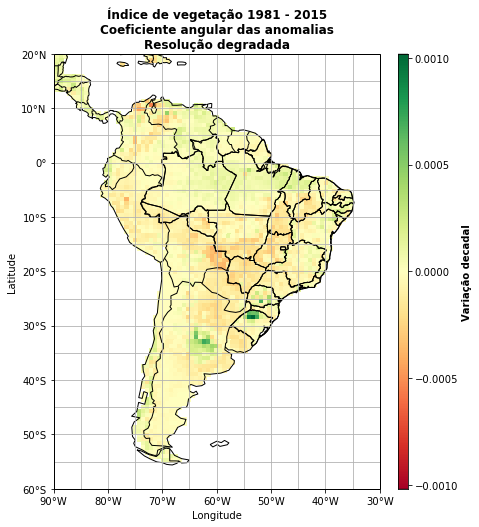

In [14]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(1, 1),
    axes_pad=0.02,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on this map.
    factor = 120
    da = (linstats_ano.sel(stats="slope") * factor).where(linstats_ano.land_mask==True)
    p = da.plot(
        ax=axis,
        cmap=plt.cm.RdYlGn,
        add_colorbar=False,
        add_labels=False
    )
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Índice de vegetação 1981 - 2015\n" + \
                     "Coeficiente angular das anomalias\n" \
                     "Resolução degradada", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Variação decadal", weight="bold")

# Statistical significant trends.
mask = linstats_ano.sel(stats="p_value") < 0.05
mask_up = linstats_ano.sel(stats="slope") > 0
mask_down = linstats_ano.sel(stats="slope") < 0
LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

## Clustering observed data

### Impose number of clusters

More or less 19 clusters coming from Köppen-Geiger classification (Kottek
et al. 2006; Peel et al. 2007).

- Kottek, M., Grieser, J., Beck, C., Rudolf, B. & Rubel, F. World map of the Köppen-Geiger climate classification updated. Meteorologische Zeitschrift 15, 259–263 (2006).

- Peel, M. C., Finlayson, B. L. & McMahon, T. A. Updated world map of the Köppen-Geiger climate classification. Hydrology and Earth System Sciences 11, 1633–1644 (2007).

In [15]:
%%time

# Let's see the influence of scaling the data in the clustering results.
scaler = StandardScaler()
clu1 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=None)
clu2 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=scaler)

# Hyper parameters.
hparams = {"n_clusters": 20 + 1,  # From Koppen-Geiger (+ 1 is from spurious sea cluster). 
           "init": "k-means++",
           "n_init": 20,
           "max_iter": 300,
           "tol": 0.0001,
           "precompute_distances": "auto",
           "verbose": 0,
           "random_state": None,
           "copy_x": True,
           "n_jobs": -1,
           "algorithm": "auto"}

# Do it.
clu1.run(hparameters=hparams)
clu2.run(hparameters=hparams)

CPU times: user 303 ms, sys: 141 ms, total: 443 ms
Wall time: 15.3 s


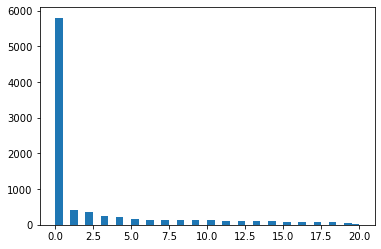

In [16]:
# Order sanity check.
plt.hist(clu1.clusters.values.flatten(), bins=40);

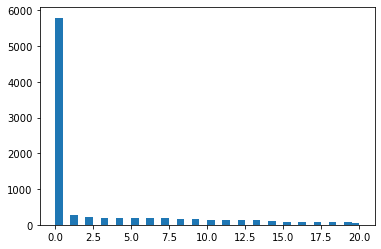

In [17]:
plt.hist(clu2.clusters.values.flatten(), bins=40);

CPU times: user 139 ms, sys: 7.54 ms, total: 146 ms
Wall time: 145 ms


Text(0.5, 0.98, 'Clusterização do índice de vegetação 1981 - 2015\n20 clusters (Köppen-Geiger)')

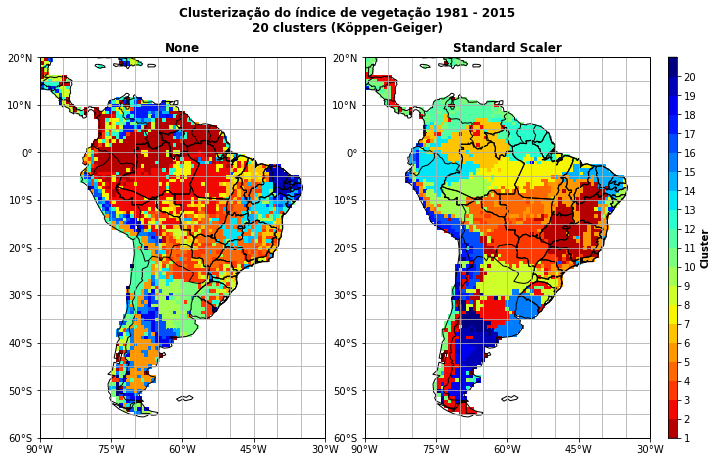

In [18]:
%%time

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(12, 7))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 2),
                axes_pad=0.55,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make maps.
da = [clu1.clusters, clu2.clusters]
titles = ["None", "Standard Scaler"]
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = da[index].where(da[index].land_mask == True).plot(
        ax=axis,
        vmin=1,
        vmax=22,
        levels=np.arange(1, 22, 1),
        cmap=plt.cm.jet_r,
        add_colorbar=False,
        add_labels=False)

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")    

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Cluster", weight="bold")
cb.cbar_axis.set_ticks(np.arange(1, 21, 1))        
plt.suptitle("Clusterização do índice de vegetação 1981 - 2015" + \
             "\n20 clusters (Köppen-Geiger)", weight="bold");

### Find the best number of clusters

In [19]:
# Hyper parameters.
hparams = {"init": "k-means++",
           "n_init": 20,
           "max_iter": 300,
           "tol": 0.0001,
           "precompute_distances": "auto",
           "verbose": 0,
           "random_state": None,
           "copy_x": True,
           "n_jobs": -1,
           "algorithm": "auto"}

scaler = StandardScaler()
clu1 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=None)
clu2 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=scaler)

In [20]:
# List over which we search the best number of clusters.
ks = np.arange(3, 26).tolist()

>>> Inertia:
* 3 clusters: 22666.892725045007; silhouette: 0.8680266395567974
* 4 clusters: 9689.575138892345; silhouette: 0.8480872221430207
* 5 clusters: 7440.462452200146; silhouette: 0.8264367146174147
* 6 clusters: 6359.162587114789; silhouette: 0.80554977849922
* 7 clusters: 5690.550175259892; silhouette: 0.7906019757222986
* 8 clusters: 5276.2225939652435; silhouette: 0.7853219587553529
* 9 clusters: 4907.508587741512; silhouette: 0.7739162877611891
* 10 clusters: 4630.336832654545; silhouette: 0.770898068752043
* 11 clusters: 4412.810055404317; silhouette: 0.7728602964840257
* 12 clusters: 4230.2767879834055; silhouette: 0.7713815221754254
* 13 clusters: 4064.796981389521; silhouette: 0.7701167996055305
* 14 clusters: 3927.9667587856866; silhouette: 0.7591005859666684
* 15 clusters: 3780.88573711708; silhouette: 0.7638184959630642
* 16 clusters: 3662.02353816; silhouette: 0.7317891935044287
* 17 clusters: 3557.8155108997703; silhouette: 0.7297378219469123
* 18 clusters: 3485.73

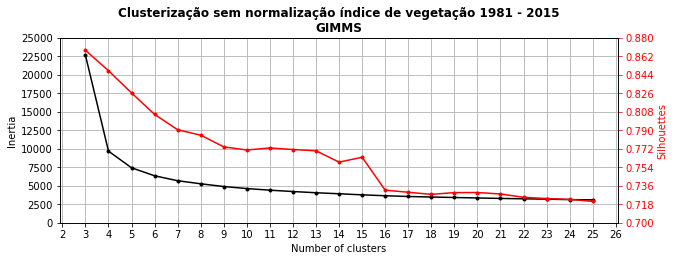

In [21]:
%%time

# No scaling.
clu1.elbow_curve_with_silhouette(hparameters=hparams, 
                                 ks=ks, 
                                 title="Clusterização sem normalização " + \
                                       "índice de vegetação 1981 - 2015\nGIMMS",
                                 verbose=True)

>>> Inertia:
* 3 clusters: 863558.8347710175; silhouette: 0.7206638819639077
* 4 clusters: 782497.2052011677; silhouette: 0.7195898649822892
* 5 clusters: 723044.9910488647; silhouette: 0.7142413646012651
* 6 clusters: 697574.3425417657; silhouette: 0.7083519236828093
* 7 clusters: 676813.10498754; silhouette: 0.7024524756683751
* 8 clusters: 660284.3496797238; silhouette: 0.7036543242971973
* 9 clusters: 648091.2761165802; silhouette: 0.7002678485542133
* 10 clusters: 636952.7411248272; silhouette: 0.6999973469205045
* 11 clusters: 627087.8661867388; silhouette: 0.6938927800474511
* 12 clusters: 618623.8559508703; silhouette: 0.6930503826660004
* 13 clusters: 611201.985133222; silhouette: 0.6910683120918248
* 14 clusters: 603160.3575610829; silhouette: 0.6932894806225944
* 15 clusters: 596061.980323246; silhouette: 0.6932767660582059
* 16 clusters: 589649.4730319137; silhouette: 0.6924936638754325
* 17 clusters: 582859.1464998295; silhouette: 0.6948147265721865
* 18 clusters: 578083.8

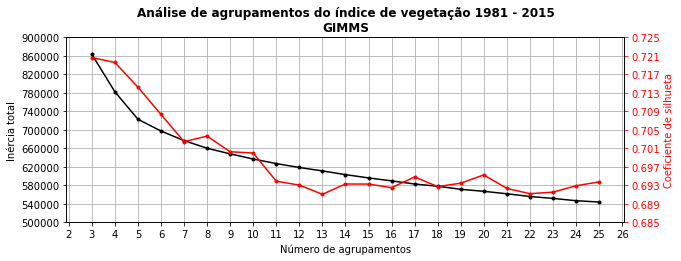

In [22]:
%%time

# No scaling.
clu2.elbow_curve_with_silhouette(hparameters=hparams, 
                                 ks=ks, 
                                 title="Análise de agrupamentos do " + \
                                       "índice de vegetação 1981 - 2015\nGIMMS",
                                 xlabel="Número de agrupamentos",
                                 ylabel_left="Inércia total",
                                 ylabel_right="Coeficiente de silhueta",
                                 verbose=True)

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_clustering_scaled_pt.jpg", dpi=200, bbox_inches="tight")

In [23]:
%%time

# Let's see the influence of scaling the data in the clustering results.
scaler = StandardScaler()
clu1 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=None)
clu2 = cdlearn.clustering.LandKmeansClustering(data_array=DA_mm, scaler=scaler)

# Hyper parameters (visual inspection).
k1 = 14 # Including spurious!
k2 = 10  # Including spurious!

hparams1 = {"n_clusters": k1, 
            "init": "k-means++",
            "n_init": 20,
            "max_iter": 300,
            "tol": 0.0001,
            "precompute_distances": "auto",
            "verbose": 0,
            "random_state": None,
            "copy_x": True,
            "n_jobs": -1,
            "algorithm": "auto"}

hparams2 = {"n_clusters": k2, 
            "init": "k-means++",
            "n_init": 20,
            "max_iter": 300,
            "tol": 0.0001,
            "precompute_distances": "auto",
            "verbose": 0,
            "random_state": None,
            "copy_x": True,
            "n_jobs": -1,
            "algorithm": "auto"}

# Do it.
clu1.run(hparameters=hparams1)
clu2.run(hparameters=hparams2)

CPU times: user 312 ms, sys: 172 ms, total: 484 ms
Wall time: 11.7 s


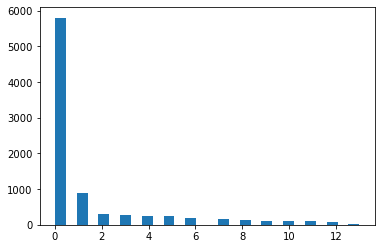

In [24]:
# Order sanity check.
plt.hist(clu1.clusters.values.flatten(), bins=2*k1);

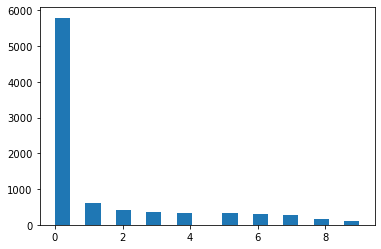

In [25]:
plt.hist(clu2.clusters.values.flatten(), bins=2*k2);

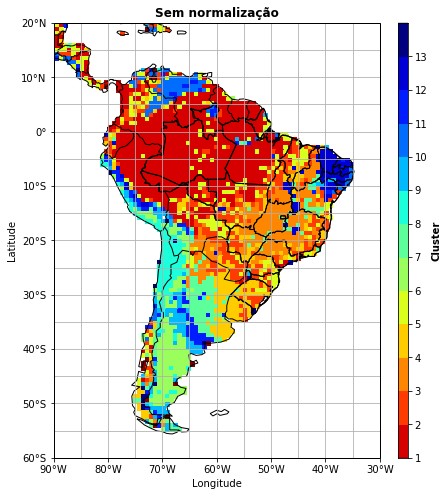

In [26]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on these maps.
    p = clu1.clusters.where(da[index].land_mask == True).plot(
        ax=axis,
        vmin=1,
        vmax=k1,
        levels=np.arange(1, k1 + 1, 1),
        cmap=plt.cm.jet_r,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Sem normalização", weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Cluster", weight="bold")
cb.cbar_axis.set_ticks(np.arange(1, k1, 1));       

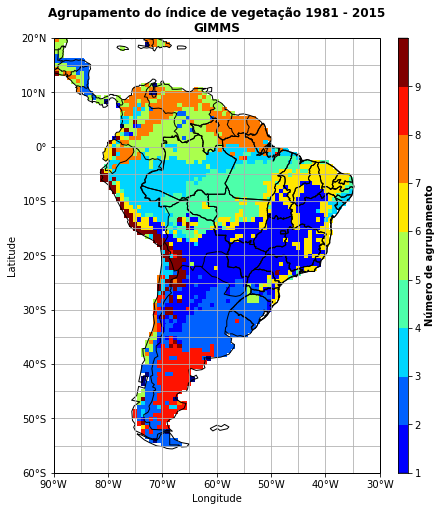

In [27]:
# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(8, 8))
axgr = AxesGrid(fig=fig, 
                rect=111, 
                axes_class=axes_class,
                nrows_ncols=(1, 1),
                axes_pad=0.02,
                cbar_location="right",
                cbar_mode="single",
                cbar_pad=0.25,
                cbar_size="3%",
                label_mode="")

# Make map.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -20, 10), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))

    # Plot data on these maps.
    p = clu2.clusters.where(da[index].land_mask == True).plot(
        ax=axis,
        vmin=1,
        vmax=k2,
        levels=np.arange(1, k2  + 1, 1),
        cmap=plt.cm.jet,
        add_colorbar=False,
        add_labels=False)
    
    # Labels.
    p.axes.set_xlabel("Longitude")
    p.axes.set_ylabel("Latitude")
    p.axes.set_title("Agrupamento do índice de vegetação 1981 - 2015\nGIMMS", 
                     weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(geoms=[state], 
                            crs=projection, 
                            facecolor="none", 
                            edgecolor="black")

# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Número de agrupamento", weight="bold")
cb.cbar_axis.set_ticks(np.arange(1, k2, 1))

# Colors from clusters.
clu2_colors = p.cmap.colors

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_clustering_scaled_map_pt.jpg", 
            dpi=200, bbox_inches="tight")

In [28]:
t = DA_mm.land_mask.sum().values
print(">>> Pixels count:", t)
npixels = []
npixels_per = []

for ncluster in range(1, k2):

    n = (clu2.clusters == ncluster).sum().values
    p = n / t * 100
    npixels.append(n)
    npixels_per.append(p)
    print("* Cluster " + str(ncluster) + ": %u; %.3f %%" %(n, p))

>>> Pixels count: 2827
* Cluster 1: 600; 21.224 %
* Cluster 2: 424; 14.998 %
* Cluster 3: 351; 12.416 %
* Cluster 4: 333; 11.779 %
* Cluster 5: 326; 11.532 %
* Cluster 6: 292; 10.329 %
* Cluster 7: 283; 10.011 %
* Cluster 8: 161; 5.695 %
* Cluster 9: 99; 3.502 %


In [29]:
# Put data in pandas DataFrame objects.
df_mean = pd.DataFrame(data=np.zeros((DA_mm.time.size, k2 - 1)), 
                       columns=["CLU" + str(i) for i in range(1, k2)], 
                       index=DA_mm.time.values)
df_std = pd.DataFrame(data=np.zeros((DA_mm.time.size, k2 - 1)), 
                      columns=["CLU" + str(i) for i in range(1, k2)], 
                      index=DA_mm.time.values)
for ncluster in range(1, k2):
    
    base = DA_mm.where(clu2.clusters == ncluster)
    mean = base.mean(["latitude", "longitude"]).values
    std = base.std(["latitude", "longitude"]).values
    df_mean.loc[:, "CLU" + str(ncluster)] = mean
    df_std.loc[:, "CLU" + str(ncluster)] = std

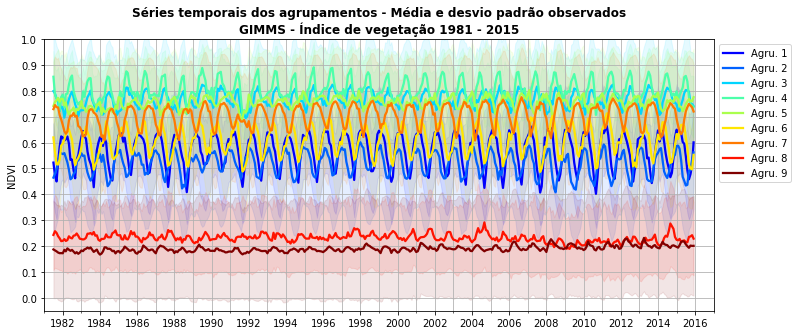

In [105]:
years = mdates.YearLocator(2)
years_fmt = mdates.DateFormatter("%Y")

# Time series of clusters means.
plt.figure(figsize=(12, 5))

x = df_mean.index
for col_num in range(k2 -1):
    
    n_pix = clu2.clusters == col_num + 1
    
    y = df_mean.iloc[:, col_num]
    sy = df_std.iloc[:, col_num]
    
    plt.plot(x, y, color=clu2_colors[col_num], linewidth=2.25, label=f"Agru. {col_num + 1}") 
    plt.fill_between(x, y - sy, y + sy, color=clu2_colors[col_num], alpha=0.1)

plt.title("Séries temporais dos agrupamentos" \
          " - Média e desvio padrão observados\n" + \
          "GIMMS - Índice de vegetação 1981 - 2015", weight="bold")    
plt.ylabel("NDVI")
plt.xlim(pd.Timestamp("1981"), pd.Timestamp("2017"))
plt.gca().set_xticks(pd.date_range(start="1981", end="2017", freq="1YS"), minor=True)
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(years_fmt)   

plt.ylim((-0.05, 1.0))    
plt.grid(which="both")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_clustering_scaled_time_series_pt.jpg", 
            dpi=200, bbox_inches="tight")

In [32]:
# Box plot.
month = 1
ncluster = 7
data = np.zeros((0, 3))

for month in range(1, 13):
    for ncluster in range(1, k2):
        
        mmask = DA_mm.time.dt.month == month
        values = DA_mm.where(clu2.clusters == ncluster)[mmask].values.flatten()
        ndvis = values[~np.isnan(values)]
        months = np.tile(month, ndvis.shape[0]).astype(np.int)
        clusters = np.tile(ncluster, ndvis.shape[0]).astype(np.int)
        data = np.append(data, np.column_stack((ndvis, months, clusters)), axis=0)
        
df_box = pd.DataFrame(data=data, columns=["NDVI", "MONTH", "AGRU."])        

In [48]:
df_box.head()

,NDVI,MONTH,AGRU.
0,0.900825,1.0,1.0
1,0.606663,1.0,1.0
2,0.703175,1.0,1.0
3,0.816050,1.0,1.0
4,0.637412,1.0,1.0


CPU times: user 3.09 s, sys: 20.6 ms, total: 3.11 s
Wall time: 3.12 s


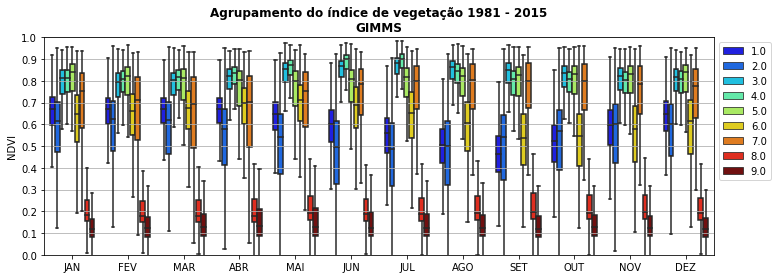

In [40]:
%%time

fig = plt.figure(figsize=(12, 4))
ax = sns.boxplot(x="MONTH", 
                 y="NDVI", 
                 hue="AGRU.", 
                 data=df_box, 
                 palette=clu2_colors,
                 ax=plt.gca(), 
                 fliersize=0)
plt.ylim((0.0, 1.0))
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.grid(axis="y")
plt.xlabel("")
ax.set_xticklabels(["JAN", "FEV", "MAR", "ABR", 
                    "MAI", "JUN", "JUL", "AGO", 
                    "SET", "OUT", "NOV", "DEZ"])
plt.title("Agrupamento do índice de vegetação 1981 - 2015\n" + \
          "GIMMS", weight="bold")

ax.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_clustering_scaled_boxplot_pt.jpg", 
            dpi=200, bbox_inches="tight")

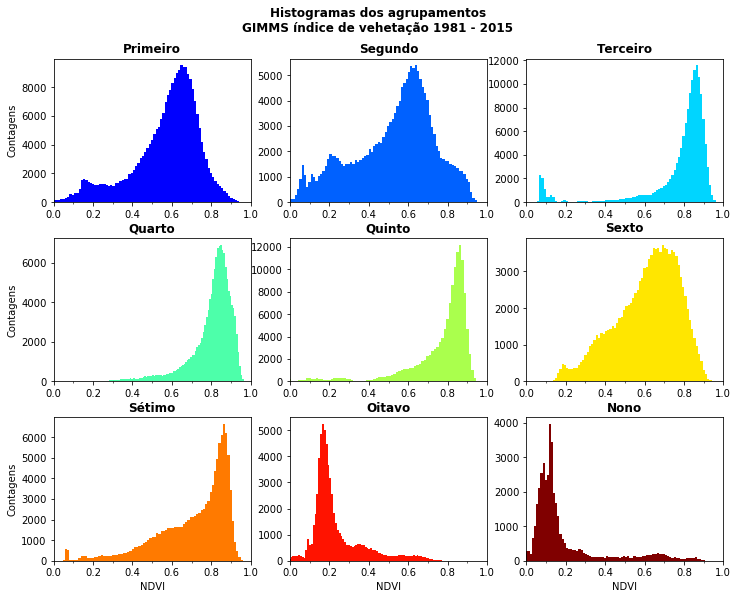

In [94]:
# Histograms for clusters.
order = ["Primeiro", "Segundo", "Terceiro",
         "Quarto", "Quinto", "Sexto",
         "Sétimo", "Oitavo", "Nono"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
for index, axis in enumerate(axes.flatten()):
    cluster = index + 1
    data = DS_mm.ndvi.where(clu2.clusters==cluster).values.flatten()
    axis.hist(data, bins=100, color=clu2_colors[index]);
    axis.set_xlim((0, 1))
    axis.set_title(order[index], weight="bold")
    axis.set_xticks([0.1, 0.3, 0.5, 0.7, 0.8, 0.9], minor=True)

plt.suptitle("Histogramas dos agrupamentos\nGIMMS índice de vehetação 1981 - 2015",
             weight="bold")
axes[-1, 0].set_xlabel("NDVI"); axes[-1, 1].set_xlabel("NDVI"); axes[-1, 2].set_xlabel("NDVI")
axes[0, 0].set_ylabel("Contagens"); axes[1, 0].set_ylabel("Contagens"); axes[2, 0].set_ylabel("Contagens")
plt.subplots_adjust(top=0.90, hspace=0.25)

# Save figure.
plt.savefig(fig_path + "ndvi_gimms_clustering_scaled_histograms_pt.jpg", 
            dpi=200, bbox_inches="tight")